## Tensorflow 2.x Setup


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import random
import numpy as np
import math
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
print(tf.__version__)

# pytorch
import torch
from torch import nn
print(torch.__version__)

# scikit-learn
import sklearn
from sklearn import cluster, decomposition, manifold, metrics
import pandas as pd

import scipy
from scipy.stats import entropy
from scipy.stats import dirichlet
import ast

# access google file system
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/'
data_dir = cwd + 'Mem_Att_RNN/data/'
dir = cwd + 'Mem_Att_RNN/plots/'

Found GPU at: /device:GPU:0
2.8.2
1.11.0+cu113
Mounted at /content/drive


### Get critic trajectories and concatenate values and rewards-to-go

In [ ]:
# shadow model (seed 1~10)
# IN: label_1 ... label_10
# OUT: label_11 ... label_20

# attack model
# attack( concat(value_traj_5, rewards_to_go_5) ) = IN
# attack( concat(value_traj_15, rewards_to_go_15) ) = OUT

# victim, whether seed 3 is used in training the target model
# attack( concat(value_traj_3, rewards_to_go_3) ) ==> IN/OUT

In [2]:
df = pd.read_csv(data_dir+'mr_gae/critic_traj.csv')
target_df = pd.read_csv(data_dir+'mr_gae_v/critic_traj.csv')

df.head()

,value,reward,env,label,corr
0,"[0.002, 0.0, 0.202, 0.202, 0.289, 0.289, 0.289...","[0.075, 0.104, 0.004, 0.029, 0.0, 0.024, 0.05,...",MiniGrid-MultiRoom-N2-v0,1,0.728538
1,"[0.346, 0.346, 0.0, 0.346, 0.345, 0.477, 0.477...","[0.0, 0.028, 0.411, 0.107, 0.142, 0.042, 0.074...",MiniGrid-MultiRoom-N2-v0,1,0.577882
2,"[0.346, 0.431, 0.346, 0.431, 0.346, 0.346, 0.4...","[0.103, 0.049, 0.098, 0.043, 0.091, 0.089, 0.0...",MiniGrid-MultiRoom-N2-v0,1,0.378762
3,"[0.002, 0.002, 0.002, 0.0, 0.0, 0.0, 0.202, 0....","[0.031, 0.056, 0.082, 0.111, 0.141, 0.172, 0.0...",MiniGrid-MultiRoom-N2-v0,1,0.600850
4,"[0.002, 0.0, 0.202, 0.202, 0.202, 0.289, 0.289...","[0.089, 0.105, 0.013, 0.023, 0.035, 0.0, 0.01,...",MiniGrid-MultiRoom-N2-v0,1,0.649842


In [39]:
def concat_data(dataframe, pad_len=64):
    # reshape the data into the shape that fit the attack model
    data = []
    for i in list(dataframe.index):
        val_traj = ast.literal_eval(dataframe['value'][i])
        rew_traj = ast.literal_eval(dataframe['reward'][i])
        if len(val_traj) < pad_len:
            val_traj = np.pad(val_traj, (pad_len-len(val_traj), 0), 
                              'constant', constant_values=(0, 0))
            rew_traj = np.pad(rew_traj, (pad_len-len(rew_traj), 0), 
                              'constant', constant_values=(0, 0))
        data.append(np.concatenate([val_traj[-pad_len:], rew_traj[-pad_len:]]))
    return np.array(data)

In [40]:
data = concat_data(df)
label = df['label'].to_numpy()
data.shape, label.shape

((1000, 128), (1000,))

In [41]:
def get_label_vector(labels):
    # Convert labels into vector form (one-hot embedding)
    label_vectors = np.zeros((len(labels), np.max(labels)+1))
    for i in range(len(labels)):
        label_vectors[i, labels[i]] = 1
    return label_vectors

def get_att_data(data, label):
    labels = get_label_vector(label)
    c = list(zip(data, labels))
    random.shuffle(c)
    data, labels = zip(*c)
    return np.array(data), np.array(labels)

In [42]:
data, labels = get_att_data(data, label)

v_data = concat_data(target_df)
v_label = target_df['label'].to_numpy()
v_data, v_labels = get_att_data(v_data, v_label)

v_data.shape, v_labels.shape

((1000, 128), (1000, 2))

### Attack Model

In [43]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Softmax, LSTM
def build_att():
    model = Sequential()
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2))
    model.add(Softmax())
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    precision = keras.metrics.Precision(class_id=0)
    recall = keras.metrics.Recall(class_id=0)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', precision, recall])
    return model

In [44]:
attack_model = build_att()
attack_model.fit(x=data, y=labels, batch_size=64, epochs=20, verbose=True)
attack_model.evaluate(x=v_data, y=v_labels, batch_size=64)

Epoch 1/20
16/16 [==============================] - 1s 4ms/step - loss: 0.5901 - accuracy: 0.6870 - precision_2: 0.6685 - recall_2: 0.7420
Epoch 2/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4854 - accuracy: 0.7570 - precision_2: 0.8640 - recall_2: 0.6100
Epoch 3/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4669 - accuracy: 0.7680 - precision_2: 0.8641 - recall_2: 0.6360
Epoch 4/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4349 - accuracy: 0.7920 - precision_2: 0.8989 - recall_2: 0.6580
Epoch 5/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4158 - accuracy: 0.7940 - precision_2: 0.8995 - recall_2: 0.6620
Epoch 6/20
16/16 [==============================] - 0s 4ms/step - loss: 0.3796 - accuracy: 0.8310 - precision_2: 0.9190 - recall_2: 0.7260
Epoch 7/20
16/16 [==============================] - 0s 4ms/step - loss: 0.3711 - accuracy: 0.8260 - precision_2: 0.8881 - recall_2: 0.7460
Epoch 8/20
16/16 [=========

[0.400907039642334, 0.8700000047683716, 0.9797979593276978, 0.831428587436676]

### Environment-based inference

In [45]:
votes = []
corrs = []
preds = []
actus = []

for env, d in df.groupby('env'):
    env_data = concat_data(d)
    env_label = np.max(d['label'].to_numpy())
    pred = np.argmax(attack_model.predict(env_data) , 1)
    pred_label = 'in' if np.sum(pred) > len(d)/2 else 'out'
    actu_label = 'in' if env_label==1 else 'out'
    votes.append(np.sum(pred))
    corrs.append(np.mean(d['corr'].to_numpy()))
    preds.append(pred_label=='in')
    actus.append(actu_label=='in')
    print('prediction: ', pred_label, 'actual: ', actu_label, 'correct: ', pred_label==actu_label)  
 
for env, d in target_df.groupby('env'):
    env_data = concat_data(d)
    env_label = np.max(d['label'].to_numpy())
    pred = np.argmax(attack_model.predict(env_data) , 1)
    pred_label = 'in' if np.sum(pred) > len(d)/2 else 'out'
    actu_label = 'in' if env_label==1 else 'out'
    votes.append(np.sum(pred))
    corrs.append(np.mean(d['corr'].to_numpy()))
    preds.append(pred_label=='in')
    actus.append(actu_label=='in')
    print('prediction: ', pred_label, 'actual: ', actu_label, 'correct: ', pred_label==actu_label)  

prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  out actual:  out correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  in correct:  True
prediction:  in actual:  out correct:  False
prediction:  out actual:  out correct:  True
prediction:  out actual:  out 

In [46]:
corrs, votes, preds, actus = np.array(corrs), np.array(votes), np.array(preds), np.array(actus)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


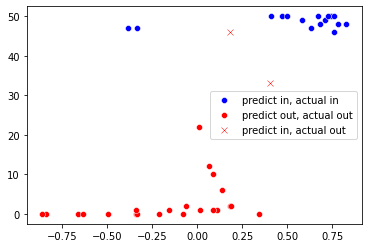

In [48]:
import seaborn as sns

idx = np.array([preds[i]==True and actus[i]==True for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], color='blue', label='predict in, actual in')

idx = np.array([preds[i]==False and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], color='red', label='predict out, actual out')

idx = np.array([preds[i]==False and actus[i]==True for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], color='blue', marker='x', label='predict out, actual in')

idx = np.array([preds[i]==True and actus[i]==False for i in range(len(preds))])
sns.scatterplot(corrs[idx], votes[idx], color='red', marker='x', label='predict in, actual out')